### Import libraries

In [2]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords

import re
from pprint import pprint 
# pprint provides a capability to “pretty-print” arbitrary Python data structures 
#    in a form which can be used as input to the interpreter

import gensim
# Gensim is a free Python library designed to automatically extract semantic topics 
#    from documents, as efficiently (computer-wise) and painlessly (human-wise) as possible
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
# simple_preprocess is a general utility function to convert a document into a list of 
#    lowercase tokens, ignoring tokens that are too short or too long
from gensim.models import CoherenceModel
# CoherenceModel allows calculating topic coherence for topic models

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis # Python library for interactive topic model visualization
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/Edgar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import the links data

In [5]:
r = requests.get('https://research.democracy.ovh/argument/links?id=88f38e1d-416a-4f16-a436-68a55fc51256', stream=True, timeout=30)
r.raise_for_status()

In [6]:
data = r.json()

In [7]:
data

{'docs': [{'hash': 'af616dc0f2c77c8ac60eab4dbf1279f1013a0b6d771dd2aa74793794975e7120',
   'content': 'The weather',
   'segments': [{'text': 'The weather'}]},
  {'hash': 'a0a0884dcc4d80c9dc10c47bc422659e8351e505235246a696ddbfbc3976645e',
   'content': 'Die derzeitige Regierung möglichst schnell absetzen bzw zur Vernunft bringen mit ihren Industriefreundlichen Vorstellungen und der alles egal Einstellung bezüglich Umwelt',
   'segments': [{'text': 'Die derzeitige Regierung möglichst schnell absetzen bzw zur Vernunft bringen mit ihren Industriefreundlichen Vorstellungen und der alles egal Einstellung bezüglich Umwelt'}]},
  {'hash': 'ce9e444326775684171bb9d4848f25da694d7214fddfc23362cbdd0d2fcabce4',
   'content': 'Stop killing trees. Kill humans.',
   'segments': [{'text': 'Stop killing trees.'}, {'text': 'Kill humans.'}]},
  {'hash': 'f3e6d15510c0afa302e4e3539bda911f3e956d23e9a8ba02b0afbf5ce1aa31da',
   'content': 'We should end the production of new plastics. Repeal the law against dis

In [8]:
# Number of answers included
len(data['docs'])

349

In [9]:
# Number of segments compared to each other
len(data['links'])

370609

In [10]:
data['links'][0]

{'source': {'doc': 'efa4e1ba6056cdd1f60f2db22195080d451c4f264526800b309b07f32db4e56d',
  'seg': 1},
 'target': {'doc': '559e57ab5d9296c5e085d861fb5154a70e7e3c69b78a5d40bf5fdca41086e71a',
  'seg': 0},
 'weight': 0.47367638}

In [11]:
# example of dataframe index
data['links'][0]['source']

{'doc': 'efa4e1ba6056cdd1f60f2db22195080d451c4f264526800b309b07f32db4e56d',
 'seg': 1}

In [12]:
# concatenating the doc hash and segment identifier
data['links'][0]['source']['doc']+'__'+str(data['links'][0]['source']['seg'])

'efa4e1ba6056cdd1f60f2db22195080d451c4f264526800b309b07f32db4e56d__1'

In [13]:
# example of dataframe column
data['links'][0]['target']

{'doc': '559e57ab5d9296c5e085d861fb5154a70e7e3c69b78a5d40bf5fdca41086e71a',
 'seg': 0}

In [14]:
# example of dataframe value
data['links'][0]['weight']

0.47367638

## Transform data into a matrix

In [15]:
# Build a table of from linker weight data
index = list()
columns = list()
weights = list()
for link in data['links']:
    source_merge = link['source']['doc']+'__'+str(link['source']['seg'])
    target_merge = link['target']['doc']+'__'+str(link['target']['seg'])
    if source_merge in index:
        continue
    else:
        index.append(source_merge)
    if target_merge in columns:
        continue
    else:
        columns.append(target_merge)
        
linker_matrix = pd.DataFrame(index = index, columns = columns)

In [16]:
# Look at document/row identifiers
linker_matrix.index

Index(['efa4e1ba6056cdd1f60f2db22195080d451c4f264526800b309b07f32db4e56d__1',
       'e21d74b168c12f4d9b20af0a0771e36b17b5310ff05675dea0bdf1ea45cf9029__3',
       '1950aa9435421254ff29e2a8830dec770c36d31ca82b47be91ff6b086866d34f__4',
       '388d4fa438fee809800a5bae02437f2f6881e1df1ecb863a7ab2d055bc8df88b__0',
       'f3e6d15510c0afa302e4e3539bda911f3e956d23e9a8ba02b0afbf5ce1aa31da__1',
       '519bf62dc8a3164f902bdedd410a7f563b373f9df241193a06021260af46f29a__0',
       '322ceafee90ca6242e4c16d74aa8bcd9f4c15c09e5c74c242d047c1b0928b130__6',
       'af9eca75be519629fef2b63164714ba16cc03a2eee4e7966b2a4d61af563ea4b__0',
       '7b23aa4a9baeba92a95c9013b914e297a0e8cb0202c7498d6e20d75e693631a8__2',
       'bed1de278c4559e43648cdc3e2d18ae1d58cecbef5ddbb140bc7d2eaeaf7a9ab__1',
       ...
       '5e09d291d36ee49cb935e6f4d20a0612c428870badd92b5ffca55647f5982fe3__5',
       '2c5aeeb400960017a95ce673b7bcc87b2ec39f8a4068dfa15e04ff6c7791de63__0',
       '5d5ec5a28d0e4542a19d540c8313924d240fa3c0bf3c7

In [19]:
print('There are {} columns and {} rows.'.format(len(columns), len(index)))


There are 486 columns and 819 rows.


In [20]:
# Fill all the fields
for link in data['links']:
    source_merge = link['source']['doc']+'__'+str(link['source']['seg'])
    target_merge = link['target']['doc']+'__'+str(link['target']['seg'])
    if source_merge in linker_matrix.index:
        if target_merge in linker_matrix.columns:
            linker_matrix[target_merge][source_merge] = link['weight']

In [21]:
# How many values and NAs are there?
print('An average column/target has {} values and {} NA values'
      .format(round(len(index)-linker_matrix.isnull().sum().mean(),ndigits=2)
              ,round(linker_matrix.isnull().sum().mean(),ndigits=2)))

An average column/target has 510.56 values and 308.44 NA values


In [22]:
linker_matrix_transposed = linker_matrix.transpose()
# How many values and NAs are there?
print('An average doc/source has {} values and {} NA values'
      .format(round(len(columns)-linker_matrix_transposed.isnull().sum().mean(),ndigits=2)
              ,round(linker_matrix_transposed.isnull().sum().mean(),ndigits=2)))

An average doc/source has 302.97 values and 183.03 NA values


In [ ]:
max(len(columns)-linker_matrix_transposed.isnull().sum())

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


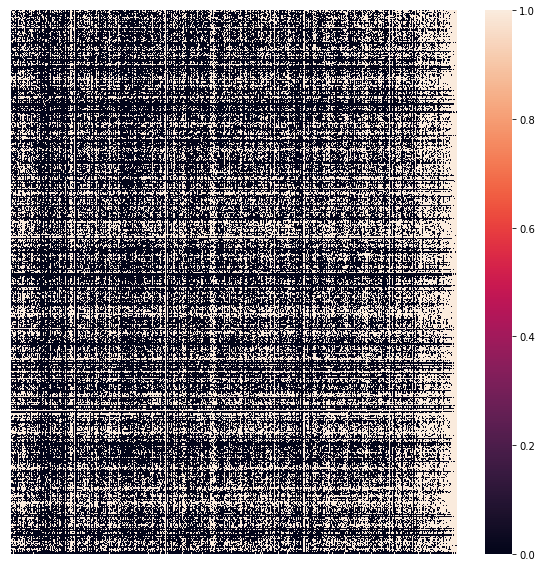

In [27]:
# Visualise the transposed NA heatmap


fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
# mask = linker_matrix.isnull()
fig = sns.heatmap(linker_matrix_transposed.isnull())
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [50]:
linker_matrix.head()

559e57ab5d9296c5e085d861fb5154a70e7e3c69b78a5d40bf5fdca41086e71a__0  \
efa4e1ba6056cdd1f60f2db22195080d451c4f264526800...                                           0.473676                    
e21d74b168c12f4d9b20af0a0771e36b17b5310ff05675d...                                           0.278423                    
1950aa9435421254ff29e2a8830dec770c36d31ca82b47b...                                           0.242732                    
388d4fa438fee809800a5bae02437f2f6881e1df1ecb863...                                                  0                    
f3e6d15510c0afa302e4e3539bda911f3e956d23e9a8ba0...                                           0.305157                    

                                                   c78365df2b9c34d8cf64503fad74b12df5bcf06b33f1f79a4b4f4f7bdadabd5c__0  \
efa4e1ba6056cdd1f60f2db22195080d451c4f264526800...                                                  0                    
e21d74b168c12f4d9b20af0a0771e36b17b5310ff05675d...                                           0.391933                    
1950aa9435421254ff29e2a8830dec770c36d31ca82b47b...                                           0.243194                    
388d4fa438fee809800a5bae02437f2f6881e1df1ecb863...                                                  0                    
f3e6d15510c0afa302e4e3539bda911f3e956d23e9a8ba0...                                           0.299661                    

                                                   9715fcce1f05cd62925ba925726f253bbd956aa88144ca3d555734ea88d67a19__1  \
efa4e1ba6056cdd1f60f2db22195080d451c4f264526800...                                                  0                    
e21d74b168c12f4d9b20af0a0771e36b17b5310ff05675d...                                           0.308171                    
1950aa9435421254ff29e2a8830dec770c36d31ca82b47b...                                           0.282923                    
388d4fa438fee809800a5bae02437f2f6881e1df1ecb863...                                           0.267347                    
f3e6d15510c0afa302e4e3539bda911f3e956d23e9a8ba0...                                           0.369741                    

                                                   4f4312007dd2697bf574b54456690ce85377771f1ace118529ac0b4d884cc981__0  \
efa4e1ba6056cdd1f60f2db22195080d451c4f264526800...                                                  0                    
e21d74b168c12f4d9b20af0a0771e36b17b5310ff05675d...                                                  0                    
1950aa9435421254ff29e2a8830dec770c36d31ca82b47b...                                                  0                    
388d4fa438fee809800a5bae02437f2f6881e1df1ecb863...                                                  0                    
f3e6d15510c0afa302e4e3539bda911f3e956d23e9a8ba0...                                                  0                    

                                                   cb1aef9c3ea2abfb92c02e460da7148df1282eb1fb2d0c43bbc5a239061f2932__0  \
efa4e1ba6056cdd1f60f2db22195080d451c4f264526800...                                           0.267162                    
e21d74b168c12f4d9b20af0a0771e36b17b5310ff05675d...                                           0.295333                    
1950aa9435421254ff29e2a8830dec770c36d31ca82b47b...                                                  0                    
388d4fa438fee809800a5bae02437f2f6881e1df1ecb863...                                           0.265316                    
f3e6d15510c0afa302e4e3539bda911f3e956d23e9a8ba0...                                           0.351115                    

                                                   bc506206c2657f1b8921215cc041e68656394d1081112c768d26adaa5e6e5751__1  \
efa4e1ba6056cdd1f60f2db22195080d451c4f264526800...                                           0.350357                    
e21d74b168c12f4d9b20af0a0771e36b17b5310ff05675d...                                            0.21894                    
1950aa9435421254ff29

In [52]:
linker_matrix.index[0]

'efa4e1ba6056cdd1f60f2db22195080d451c4f264526800b309b07f32db4e56d__1'

In [53]:
data['docs']

[{'hash': 'af616dc0f2c77c8ac60eab4dbf1279f1013a0b6d771dd2aa74793794975e7120',
  'content': 'The weather',
  'segments': [{'text': 'The weather'}]},
 {'hash': 'a0a0884dcc4d80c9dc10c47bc422659e8351e505235246a696ddbfbc3976645e',
  'content': 'Die derzeitige Regierung möglichst schnell absetzen bzw zur Vernunft bringen mit ihren Industriefreundlichen Vorstellungen und der alles egal Einstellung bezüglich Umwelt',
  'segments': [{'text': 'Die derzeitige Regierung möglichst schnell absetzen bzw zur Vernunft bringen mit ihren Industriefreundlichen Vorstellungen und der alles egal Einstellung bezüglich Umwelt'}]},
 {'hash': 'ce9e444326775684171bb9d4848f25da694d7214fddfc23362cbdd0d2fcabce4',
  'content': 'Stop killing trees. Kill humans.',
  'segments': [{'text': 'Stop killing trees.'}, {'text': 'Kill humans.'}]},
 {'hash': 'f3e6d15510c0afa302e4e3539bda911f3e956d23e9a8ba02b0afbf5ce1aa31da',
  'content': 'We should end the production of new plastics. Repeal the law against distilling so the aver

## Build the vector space from segments

In [23]:
data['docs'][0]

{'hash': 'af616dc0f2c77c8ac60eab4dbf1279f1013a0b6d771dd2aa74793794975e7120',
 'content': 'The weather',
 'segments': [{'text': 'The weather'}]}

In [24]:
data['docs'][0]['hash']

'af616dc0f2c77c8ac60eab4dbf1279f1013a0b6d771dd2aa74793794975e7120'

In [27]:
data['docs'][0]['segments']

[{'text': 'The weather'}]

In [31]:
data['docs'][0]['segments'][0]['text']

'The weather'

In [101]:
segments = list()
hash_seg_identifiers = list()
for doc in data['docs']:
    doc_hash = doc['hash']
    i = 0
    for segment in doc['segments']:
        doc_segment = segment['text']
        segments.append(doc_segment)
        
        hash_seg_identifier = doc_hash+'__'+str(i)
        hash_seg_identifiers.append(hash_seg_identifier)
        
        i+=1
        
segmented_doc_dataframe = pd.DataFrame(data=segments, index = hash_seg_identifiers, columns = ['doc_segment'])

In [102]:
linker_matrix_transposed.head()

efa4e1ba6056cdd1f60f2db22195080d451c4f264526800b309b07f32db4e56d__1  \
559e57ab5d9296c5e085d861fb5154a70e7e3c69b78a5d4...                                           0.473676                    
c78365df2b9c34d8cf64503fad74b12df5bcf06b33f1f79...                                                  0                    
9715fcce1f05cd62925ba925726f253bbd956aa88144ca3...                                                  0                    
4f4312007dd2697bf574b54456690ce85377771f1ace118...                                                  0                    
cb1aef9c3ea2abfb92c02e460da7148df1282eb1fb2d0c4...                                           0.267162                    

                                                   e21d74b168c12f4d9b20af0a0771e36b17b5310ff05675dea0bdf1ea45cf9029__3  \
559e57ab5d9296c5e085d861fb5154a70e7e3c69b78a5d4...                                           0.278423                    
c78365df2b9c34d8cf64503fad74b12df5bcf06b33f1f79...                                           0.391933                    
9715fcce1f05cd62925ba925726f253bbd956aa88144ca3...                                           0.308171                    
4f4312007dd2697bf574b54456690ce85377771f1ace118...                                                  0                    
cb1aef9c3ea2abfb92c02e460da7148df1282eb1fb2d0c4...                                           0.295333                    

                                                   1950aa9435421254ff29e2a8830dec770c36d31ca82b47be91ff6b086866d34f__4  \
559e57ab5d9296c5e085d861fb5154a70e7e3c69b78a5d4...                                           0.242732                    
c78365df2b9c34d8cf64503fad74b12df5bcf06b33f1f79...                                           0.243194                    
9715fcce1f05cd62925ba925726f253bbd956aa88144ca3...                                           0.282923                    
4f4312007dd2697bf574b54456690ce85377771f1ace118...                                                  0                    
cb1aef9c3ea2abfb92c02e460da7148df1282eb1fb2d0c4...                                                  0                    

                                                   388d4fa438fee809800a5bae02437f2f6881e1df1ecb863a7ab2d055bc8df88b__0  \
559e57ab5d9296c5e085d861fb5154a70e7e3c69b78a5d4...                                                  0                    
c78365df2b9c34d8cf64503fad74b12df5bcf06b33f1f79...                                                  0                    
9715fcce1f05cd62925ba925726f253bbd956aa88144ca3...                                           0.267347                    
4f4312007dd2697bf574b54456690ce85377771f1ace118...                                                  0                    
cb1aef9c3ea2abfb92c02e460da7148df1282eb1fb2d0c4...                                           0.265316                    

                                                   f3e6d15510c0afa302e4e3539bda911f3e956d23e9a8ba02b0afbf5ce1aa31da__1  \
559e57ab5d9296c5e085d861fb5154a70e7e3c69b78a5d4...                                           0.305157                    
c78365df2b9c34d8cf64503fad74b12df5bcf06b33f1f79...                                           0.299661                    
9715fcce1f05cd62925ba925726f253bbd956aa88144ca3...                                           0.369741                    
4f4312007dd2697bf574b54456690ce85377771f1ace118...                                                  0                    
cb1aef9c3ea2abfb92c02e460da7148df1282eb1fb2d0c4...                                           0.351115                    

                                                   519bf62dc8a3164f902bdedd410a7f563b373f9df241193a06021260af46f29a__0  \
559e57ab5d9296c5e085d861fb5154a70e7e3c69b78a5d4...                                           0.272726                    
c78365df2b9c34d8cf64503fad74b12df5bcf06b33f1f79...                                                  0                    
9715fcce1f05cd62925b

In [34]:
len(hash_seg_identifiers)

819

In [103]:
segmented_doc_dataframe.head()

doc_segment
af616dc0f2c77c8ac60eab4dbf1279f1013a0b6d771dd2a...                                        The weather
a0a0884dcc4d80c9dc10c47bc422659e8351e505235246a...  Die derzeitige Regierung möglichst schnell abs...
ce9e444326775684171bb9d4848f25da694d7214fddfc23...                                Stop killing trees.
ce9e444326775684171bb9d4848f25da694d7214fddfc23...                                       Kill humans.
f3e6d15510c0afa302e4e3539bda911f3e956d23e9a8ba0...      We should end the production of new plastics.

In [36]:
type(segmented_doc_dataframe['doc_segment'])

pandas.core.series.Series

Import tSNE and Truncated SVD methods. Since the tf-idf method results in a sparse matrix which cannot be read in by tSNE (http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), truncatedSVD will be used to reduce the number of dimensions to a reasonable amount, a 100 in this case. 

In [37]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
#tsvd = TruncatedSVD(n_components = 100)

In [39]:
#reduced_dims = tsvd.fit_transform(X = x)

In [48]:
# Replace NaNs with zeros
where_are_NaNs = pd.isnull(linker_matrix)
linker_matrix[where_are_NaNs] = 0
#linker_matrix_transposed.head(n=20)

The resulting output of tSNE is highly affected by the hyperparameters that are used for model building. Since we don't know beforehand, which combinations of hyperparameters give meaningful results, we're going to try a few.

Generate a hyperparameter grid from where we can loop through every possible combination and use it for model building.

In [41]:
param_grid = {'perplexity': [5,10,20,50], 'learning_rate': [10,25,50,100,200], 'n_iter': [250,500,1000]}

This piece of code creates a pandas dataframe of all the results that are created for each hyperparameter combination, creating a big data frame. It might take a while to run this code depending on how many answers are fed into it and how many hyperparameter combinations are tried. 

In [56]:
all_variations = pd.DataFrame()
for perplex in range(0,len(param_grid['perplexity'])):
    for learn_rate in range(0,len(param_grid['learning_rate'])):
        for n_iter in range(0,len(param_grid['n_iter'])):
            tsne_model = TSNE(n_components=3
                          , perplexity=param_grid['perplexity'][perplex]
                          , learning_rate=param_grid['learning_rate'][learn_rate]
                          , n_iter=param_grid['n_iter'][n_iter])
            tsne_features = tsne_model.fit_transform(X = linker_matrix)
            
            tsne_frame = pd.DataFrame(tsne_features, columns=['feature1', 'feature2', 'feature3'])
            
            params_frame = pd.concat([pd.Series([param_grid['perplexity'][perplex]]*len(tsne_frame.index), name = 'perplexity')
                          , pd.Series([param_grid['learning_rate'][learn_rate]]*len(tsne_frame.index), name = 'learning_rate')
                          , pd.Series([param_grid['n_iter'][n_iter]]*len(tsne_frame.index), name = 'iterations')]
                         , axis=1
                         , names=['perplex', 'learn_rate', 'n_iter'])
            
            complete_run = pd.concat([pd.Series(linker_matrix.index), tsne_frame, params_frame], axis=1)
            all_variations = all_variations.append(complete_run)


In [70]:
# rename the doc identifier column from '0' to 'doc_segment'
all_variations.rename(columns = {0:'doc_segment'}, inplace = True)

In [108]:
# Set the doc_segment identifier as index for merging purposes later on.
all_variations.set_index('doc_segment', inplace=True)

### Match hash_segment identifiers with segment text

In [133]:
tsne_variations_w_text = all_variations.join(segmented_doc_dataframe, how='outer')
tsne_variations_w_text.rename(columns = {'doc_segment':'segment_text'}, inplace = True)

In [134]:
tsne_variations_w_text.head(100)

feature1    feature2  \
015182827bb38ba72b72d708e565daaa77c639fbe333264...  -0.085098   -0.129324   
015182827bb38ba72b72d708e565daaa77c639fbe333264...   9.078564   -2.088567   
015182827bb38ba72b72d708e565daaa77c639fbe333264... -13.224530  -20.066969   
015182827bb38ba72b72d708e565daaa77c639fbe333264...   1.248951    0.197865   
015182827bb38ba72b72d708e565daaa77c639fbe333264... -22.393618   -1.244064   
015182827bb38ba72b72d708e565daaa77c639fbe333264...  40.953636   -8.409514   
015182827bb38ba72b72d708e565daaa77c639fbe333264...  -0.910605    0.003573   
015182827bb38ba72b72d708e565daaa77c639fbe333264... -21.168789  -17.183775   
015182827bb38ba72b72d708e565daaa77c639fbe333264... -43.020123   18.582644   
015182827bb38ba72b72d708e565daaa77c639fbe333264...  -0.935722   -3.084323   
015182827bb38ba72b72d708e565daaa77c639fbe333264...  -5.721746  -29.786623   
015182827bb38ba72b72d708e565daaa77c639fbe333264... -32.753651   -8.460899   
015182827bb38ba72b72d708e565daaa77c639fbe333264...   1.245023   -3.630388   
015182827bb38ba72b72d708e565daaa77c639fbe333264... -27.437035    2.919793   
015182827bb38ba72b72d708e565daaa77c639fbe333264...  25.911711  -47.363476   
015182827bb38ba72b72d708e565daaa77c639fbe333264...   0.008714    0.002969   
015182827bb38ba72b72d708e565daaa77c639fbe333264...  -1.345023  -12.360726   
015182827bb38ba72b72d708e565daaa77c639fbe333264... -18.190113   -8.648166   
015182827bb38ba72b72d708e565daaa77c639fbe333264...  -0.079082    0.398624   
015182827bb38ba72b72d708e565daaa77c639fbe333264... -12.491588    9.926682   
015182827bb38ba72b72d708e565daaa77c639fbe333264...  36.029331   -6.434958   
015182827bb38ba72b72d708e565daaa77c639fbe333264...   1.250340    0.493380   
015182827bb38ba72b72d708e565daaa77c639fbe333264...  20.362501   16.504120   
015182827bb38ba72b72d708e565daaa77c639fbe333264...  21.740185   41.156910   
015182827bb38ba72b72d708e565daaa77c639fbe333264...   0.369737    1.835946   
015182827bb38ba72b72d708e565daaa77c639fbe333264... -15.806050    1.435494   
015182827bb38ba72b72d708e565daaa77c639fbe333264...   7.988482   63.792648   
015182827bb38ba72b72d708e565daaa77c639fbe333264...   0.975906    2.329230   
015182827bb38ba72b72d708e565daaa77c639fbe333264... -31.999540  -33.620930   
015182827bb38ba72b72d708e565daaa77c639fbe333264... -29.932095  -74.713379   
...                                                       ...         ...   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  24.889292   31.868912   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  42.765659   -0.614346   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  -0.616571    3.854964   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  24.167618   30.288881   
025f0ed23c117b2caae1d666879629a28682992e33f9042... -80.077553   39.472141   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  -0.060105   -0.020617   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  -1.353634    9.431598   
025f0ed23c117b2caae1d666879629a28682992e33f9042...   8.931670   15.506694   
025f0ed23c117b2caae1d666879629a28682992e33f9042...   0.089110   -0.619221   
025f0ed23c117b2caae1d666879629a28682992e33f9042...   6.680285   -9.641714   
025f0ed23c117b2caae1d666879629a28682992e33f9042... -14.543934    5.205532   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  -1.634418   -0.456336   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  -7.179516  -26.860350   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  -0.370641  -20.139919   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  -0.665370   -0.943068   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  11.652637   -6.855519   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  21.410696  -90.648903   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  -2.602145   -1.237136   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  29.178297  -11.883889   
025f0ed23c117b2caae1d666879629a28682992e33f9042...  41.825108  135.853622   
025f0ed23c117b2caae1d666879629a28682992e33f9042..

In [120]:
## Upload to Bigquery

In [128]:
import os
os.getcwd()

'/Users/Edgar/Google Drive/Client-projects/Digital Peace Talks'

Here, complete some post-processing so that the results could be visualized by a Data Studio dashboard. The tabs and line changes are removed, because they cause problems during upload.

In [138]:
tsne_variations_w_text['segment_text'] = tsne_variations_w_text['segment_text'].apply(lambda x: str.replace(x, ',',' '))
tsne_variations_w_text['segment_text'] = tsne_variations_w_text['segment_text'].apply(lambda x: str.replace(x, '\r',' '))
tsne_variations_w_text['segment_text'] = tsne_variations_w_text['segment_text'].apply(lambda x: str.replace(x, '\n',' '))
tsne_variations_w_text['segment_text'] = tsne_variations_w_text['segment_text'].apply(lambda x: str.replace(x, '\t',' '))




In [139]:

tsne_variations_w_text.to_gbq(destination_table = 'tSNE_clustering.tSNE_variations_from_ADW',
                             project_id = 'digital-peace-talks',
                             if_exists = 'replace',
                             reauth = False,
                             private_key = 'digital-peace-talks-e997b7d20227.json')


0it [00:00, ?it/s]
1it [00:00,  1.70it/s]


## Create all visualizations of all combinations

This piece of code loops through every combination of tSNE hyperparameters, generates a model and creates 3 tSNE features for each answer and and then plots the results in a scatterplot using seaborn. This code might take a while to run depending on how many combinations of hyperparameters are fed in with the param_grid.


/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


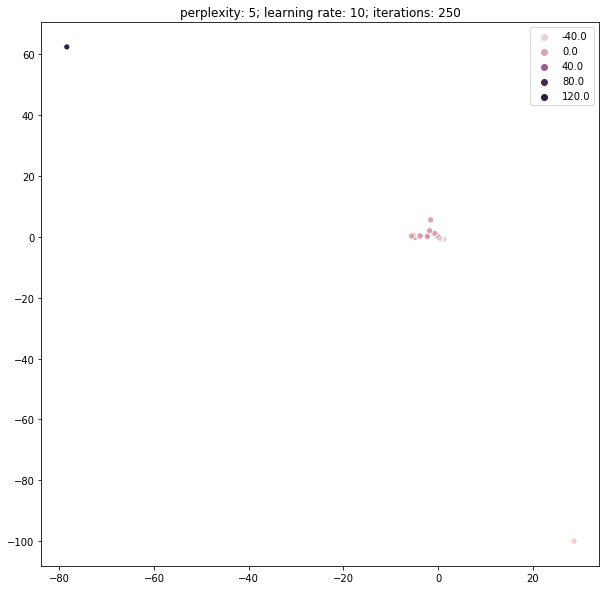

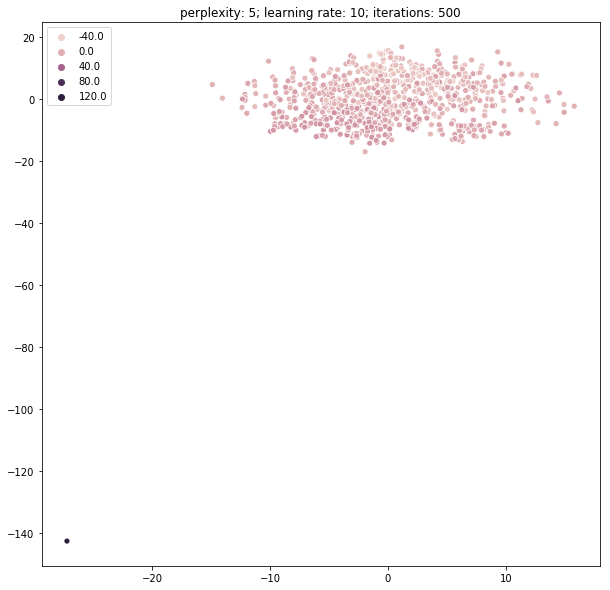

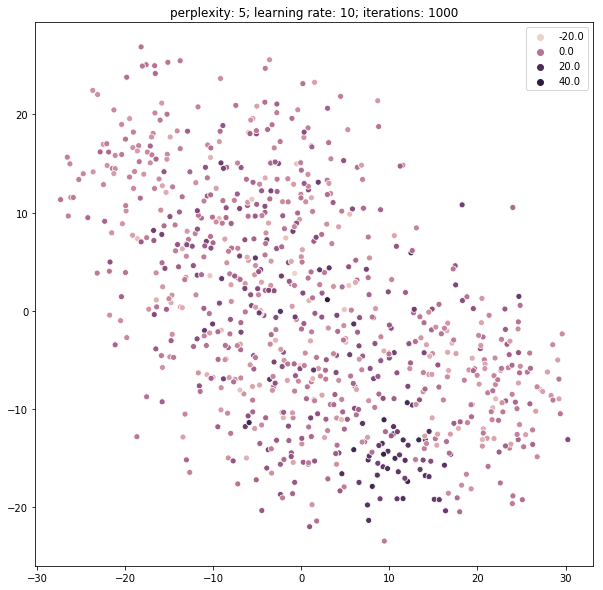

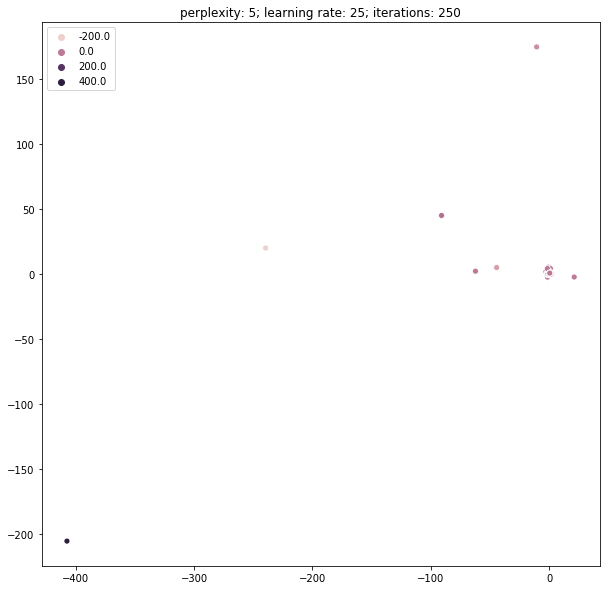

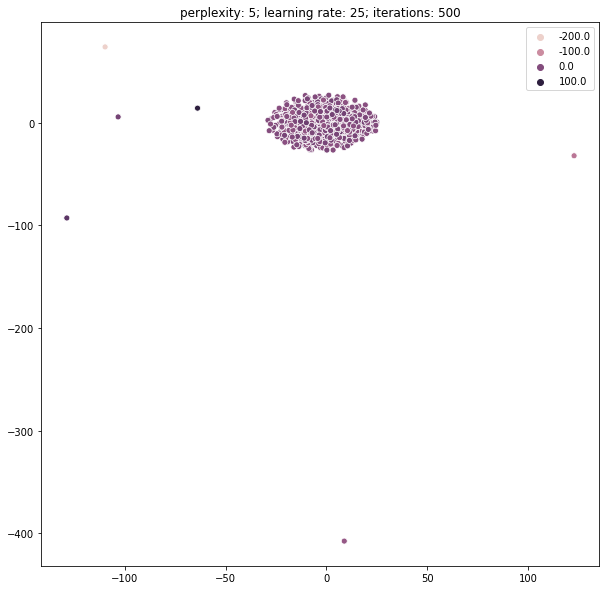

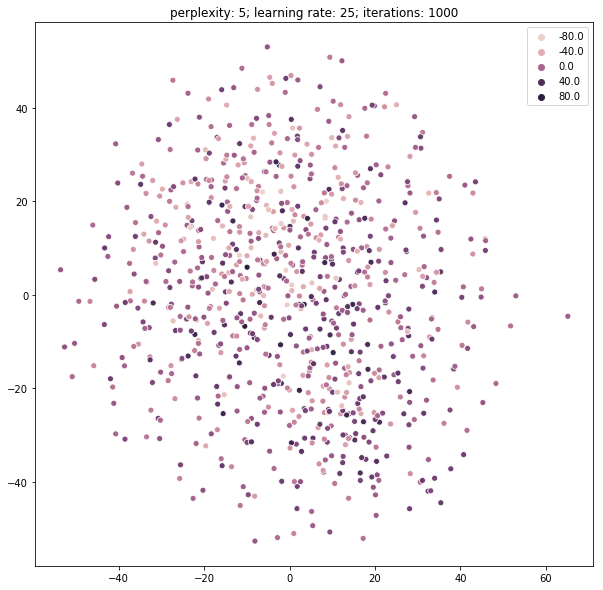

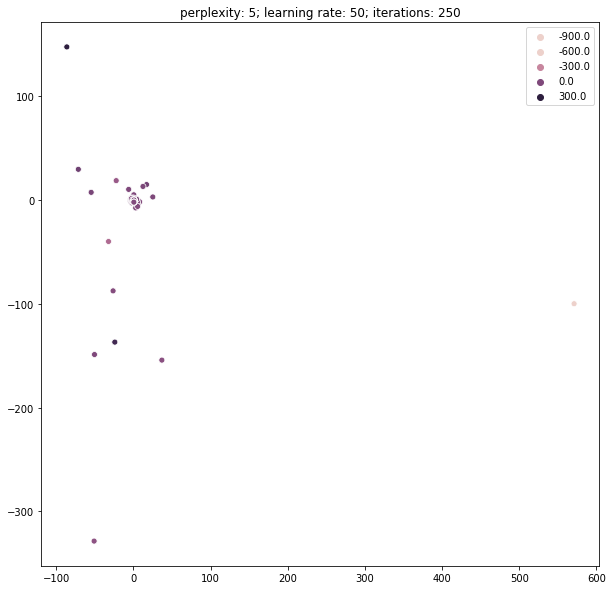

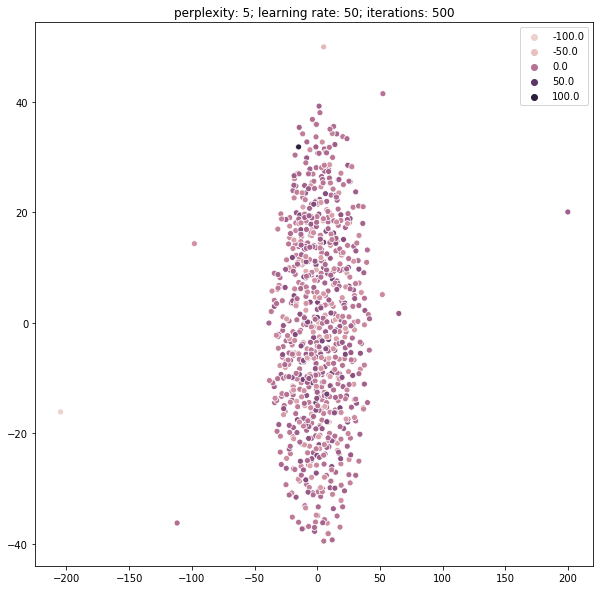

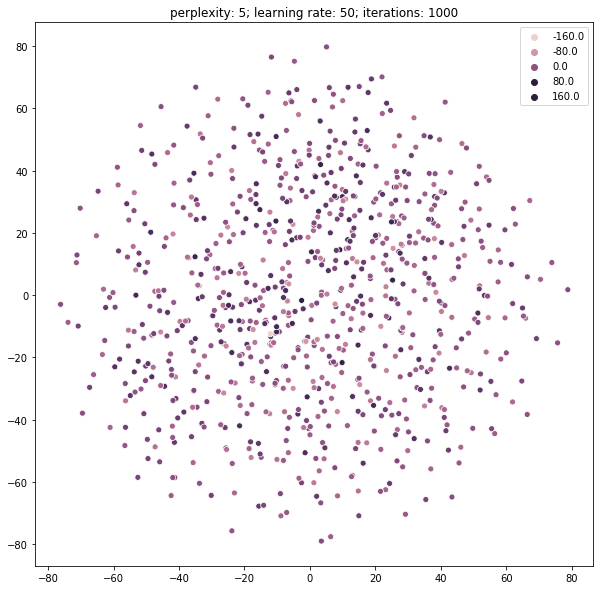

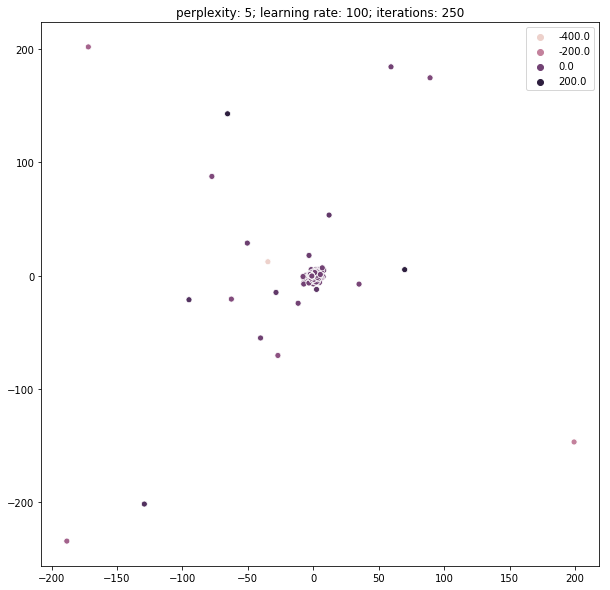

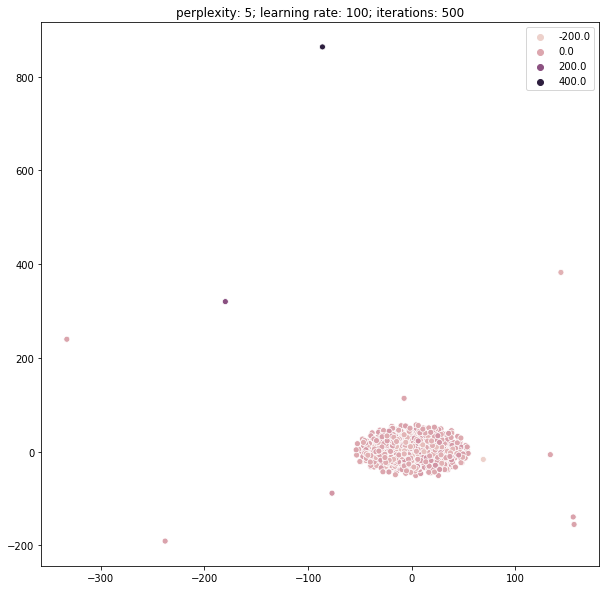

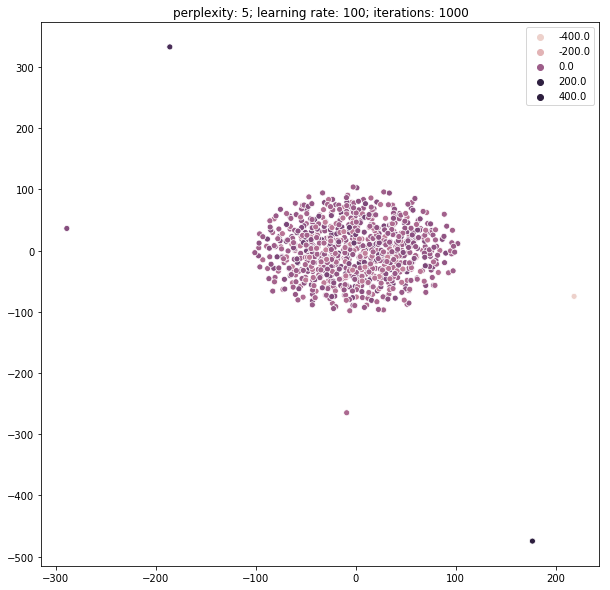

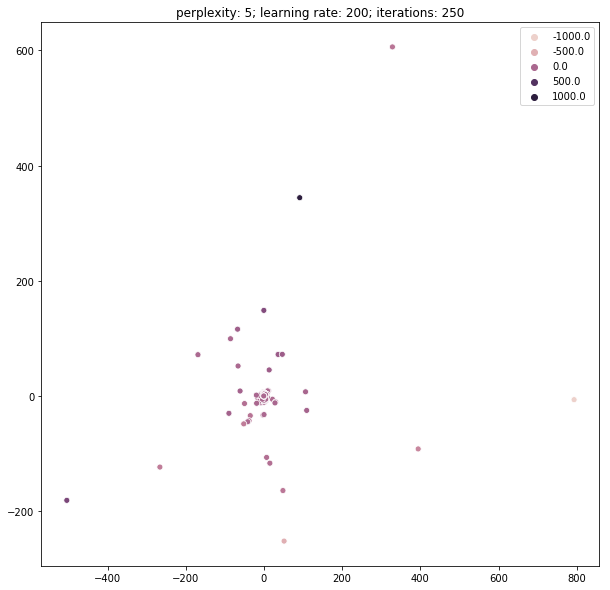

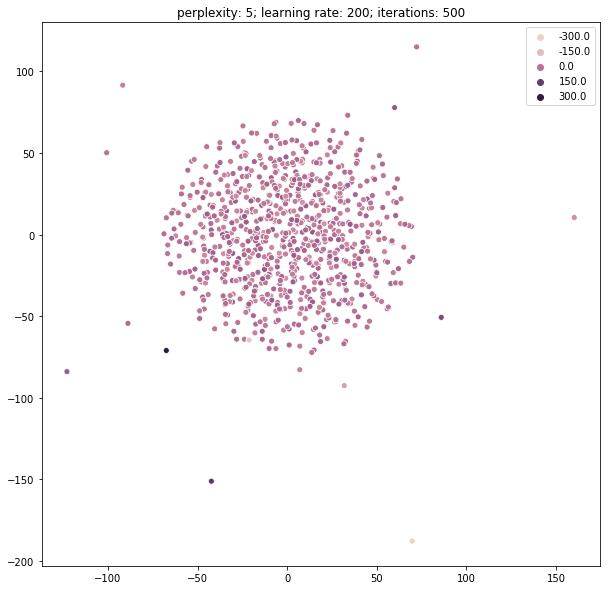

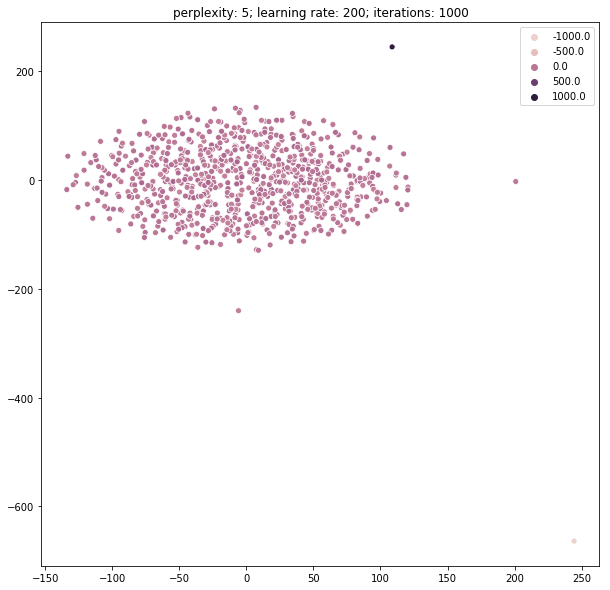

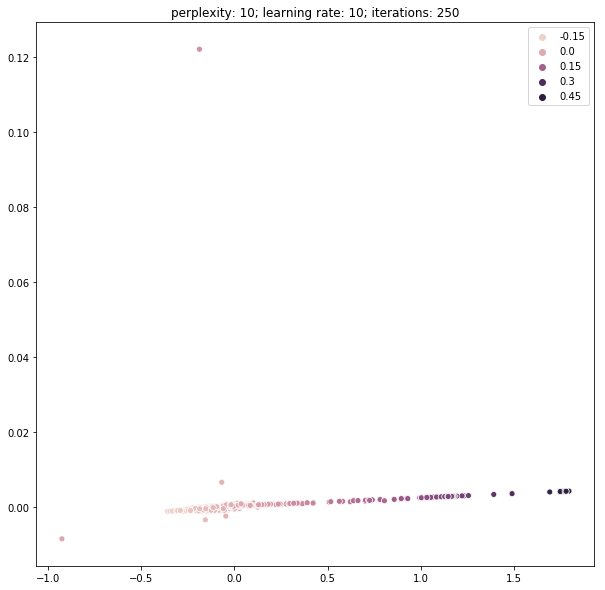

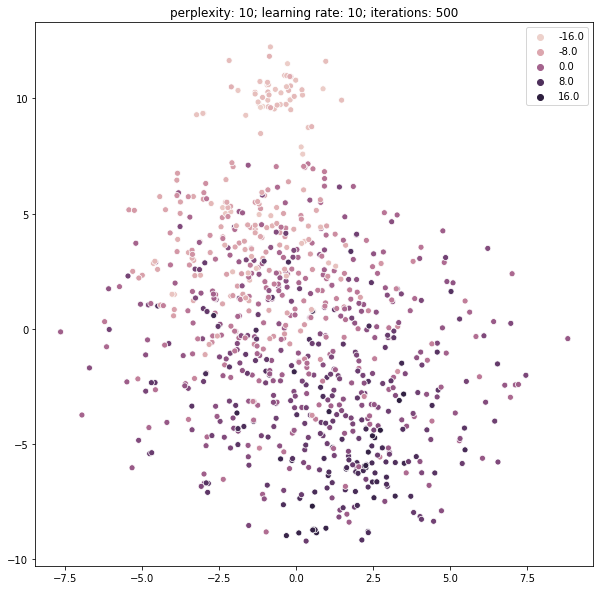

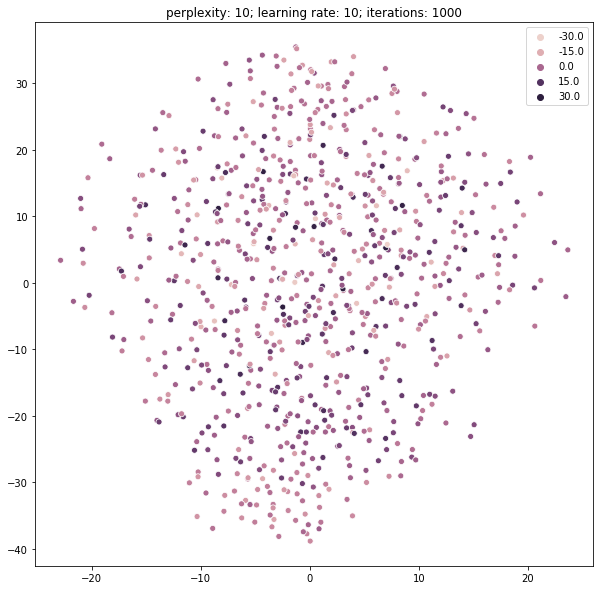

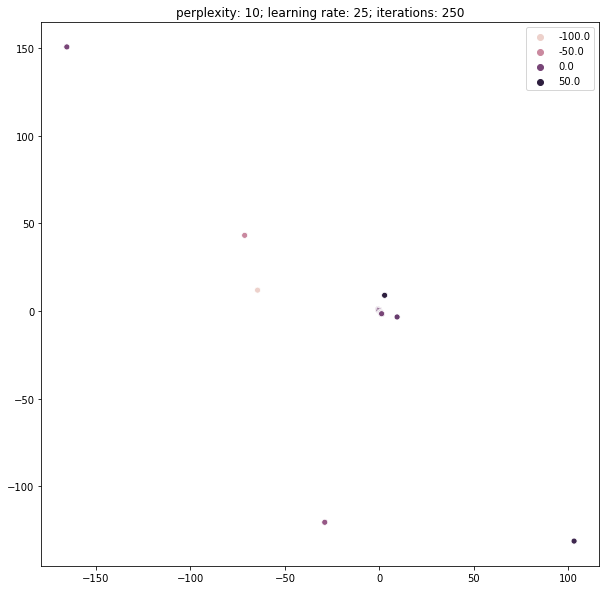

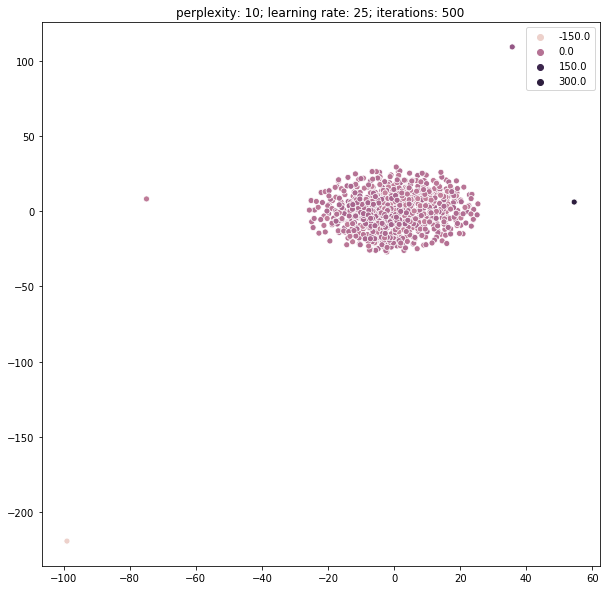

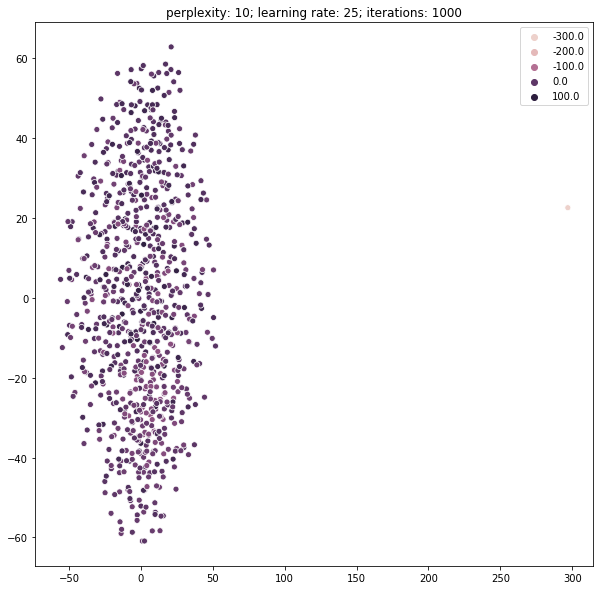

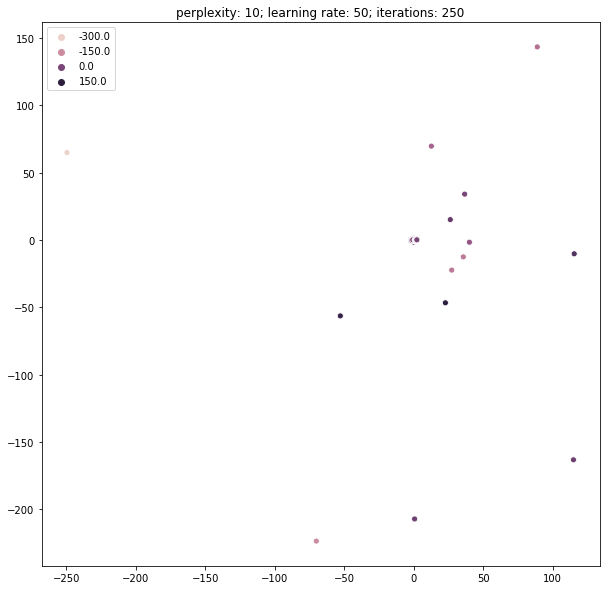

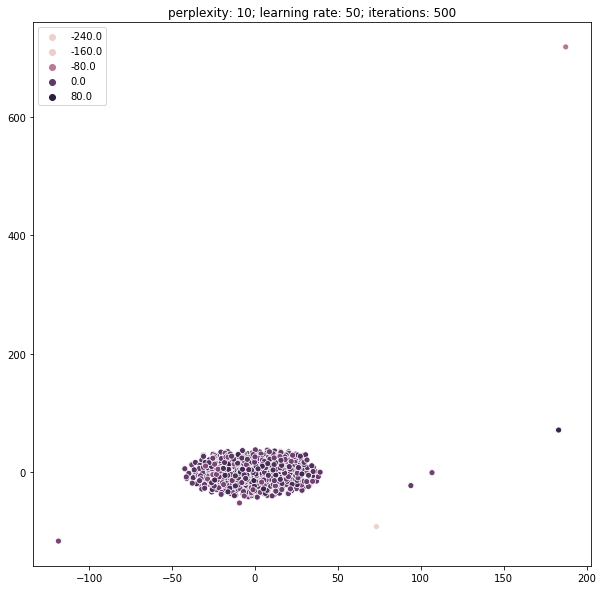

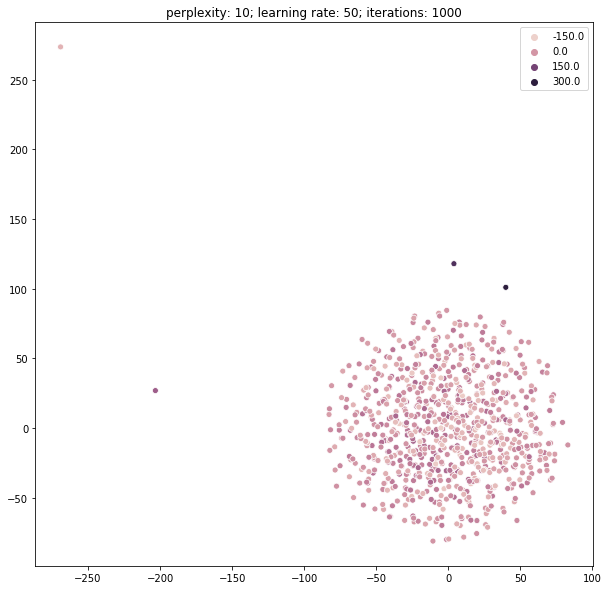

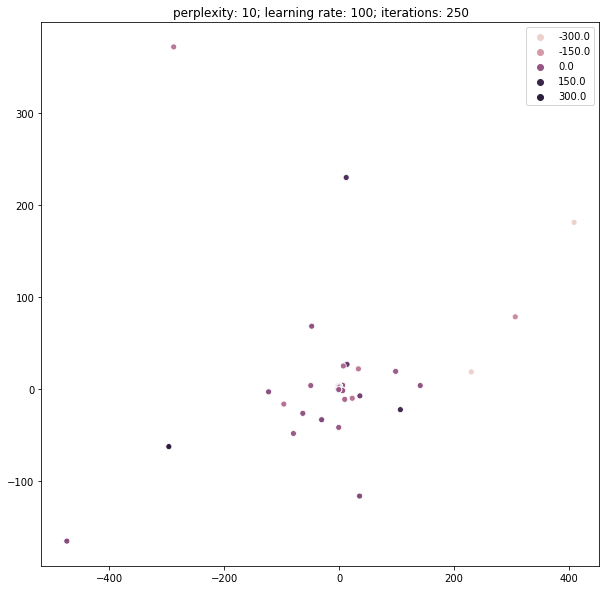

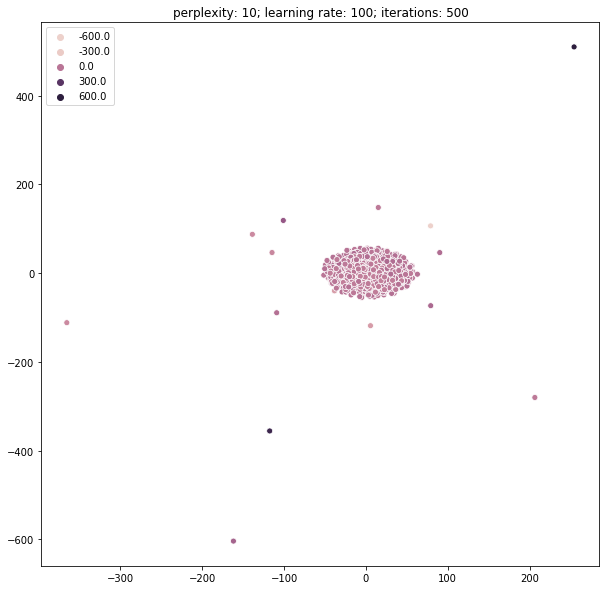

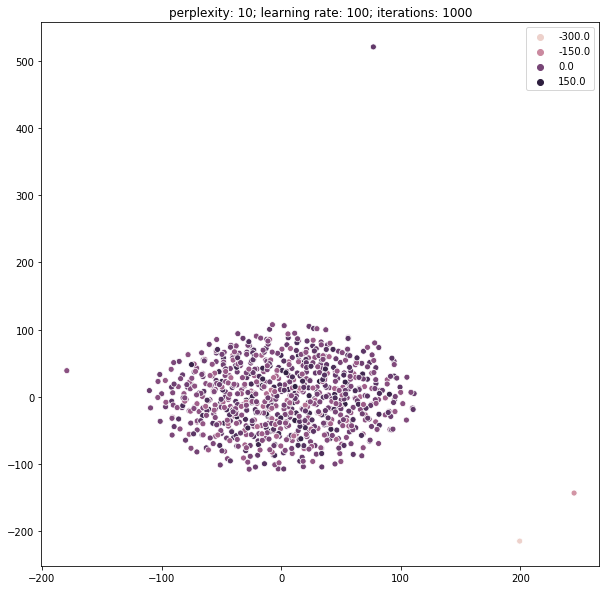

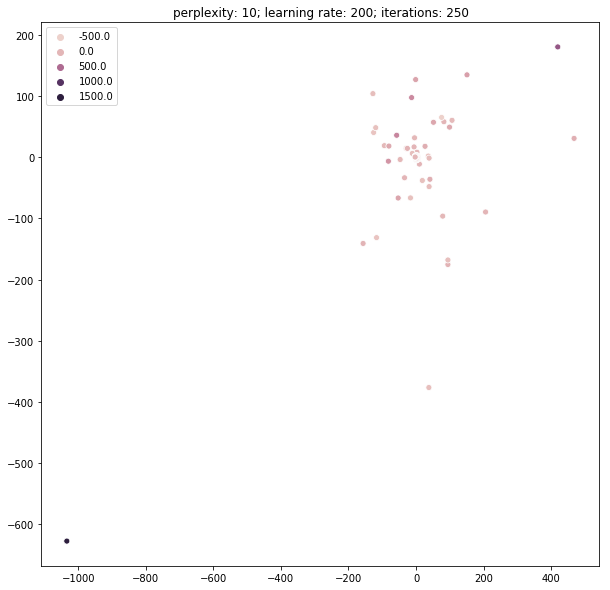

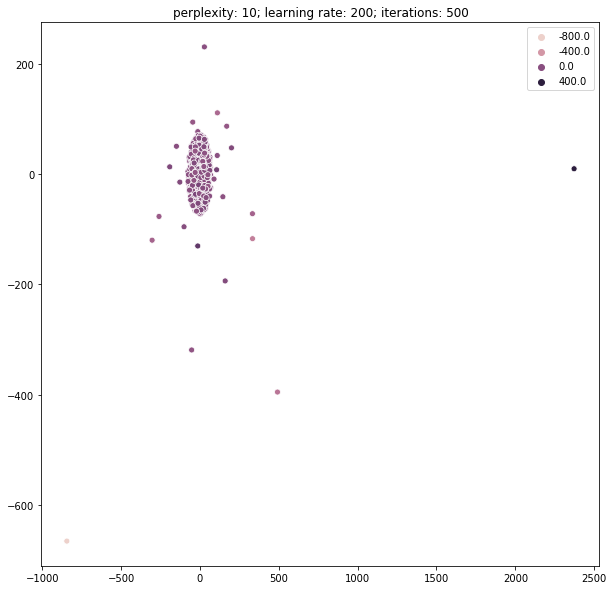

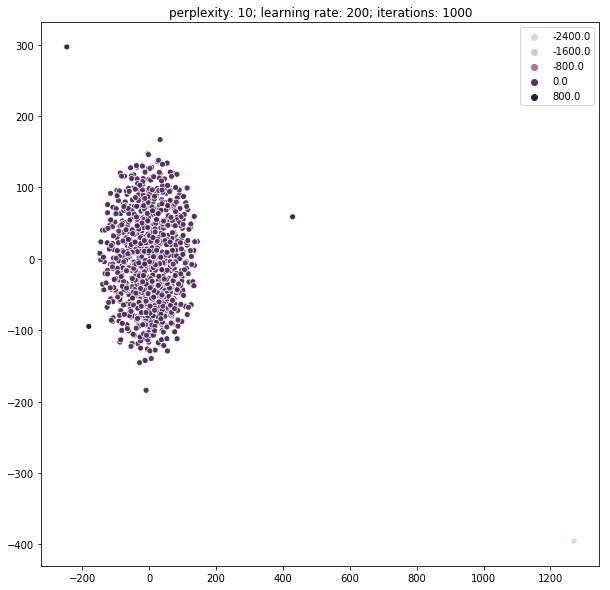

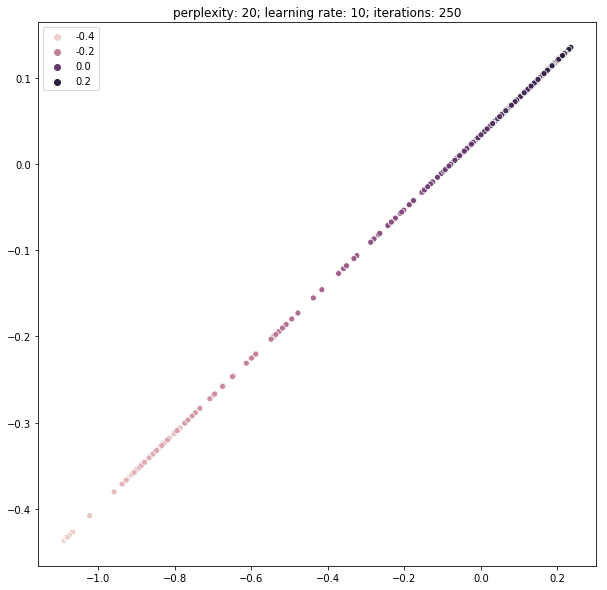

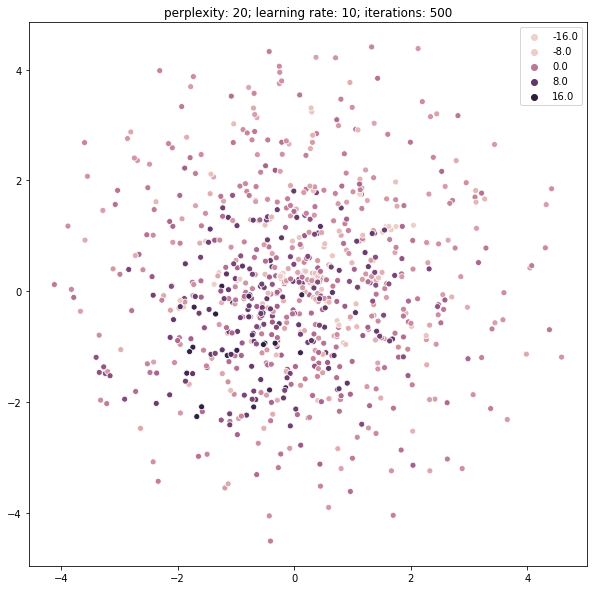

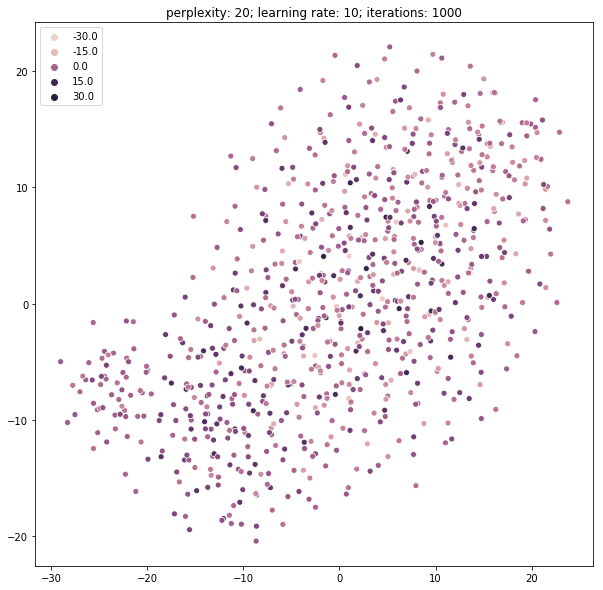

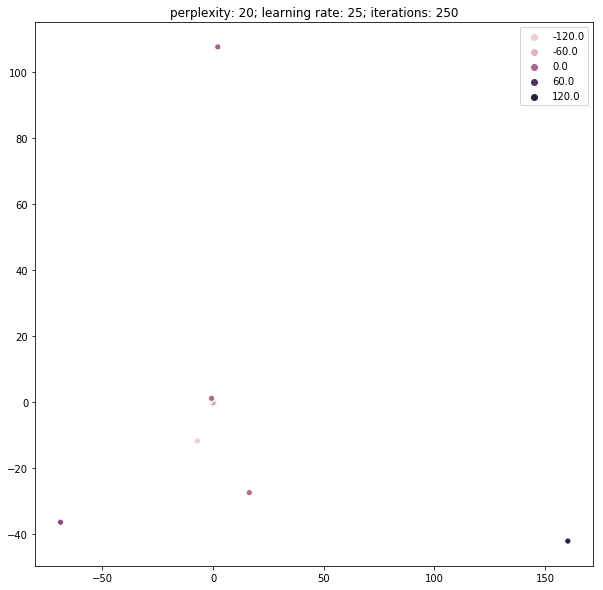

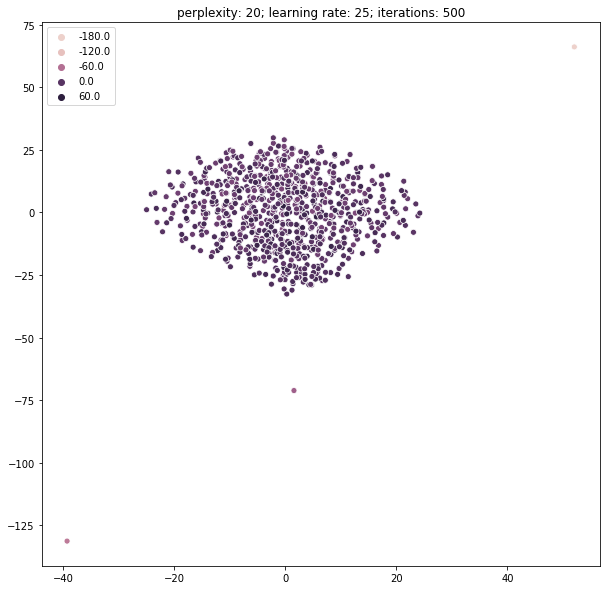

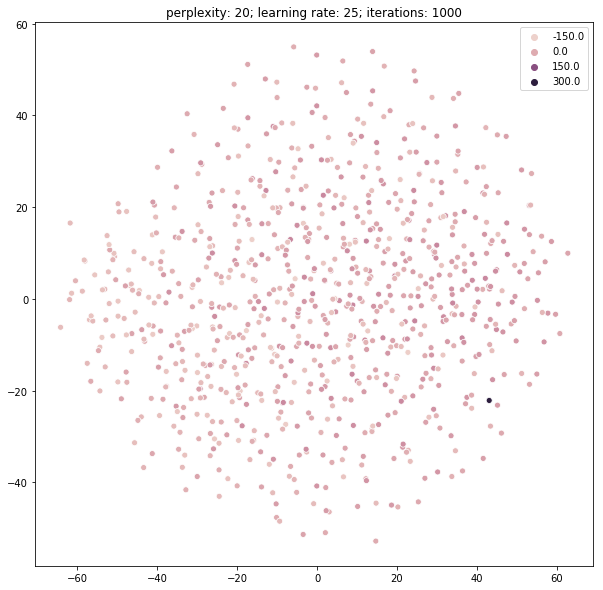

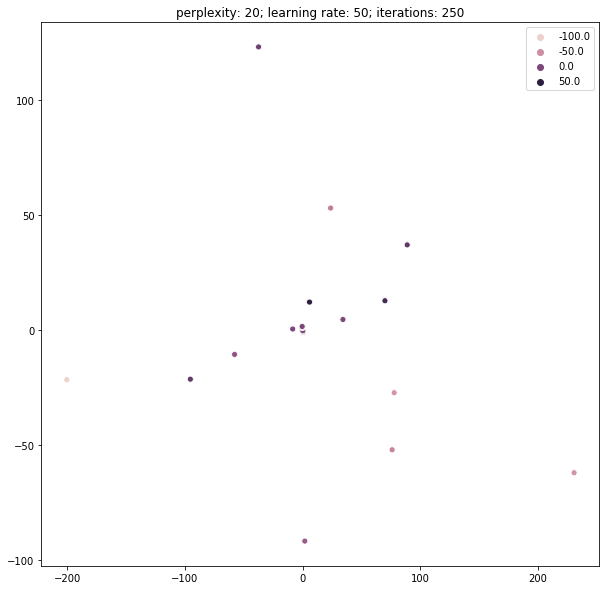

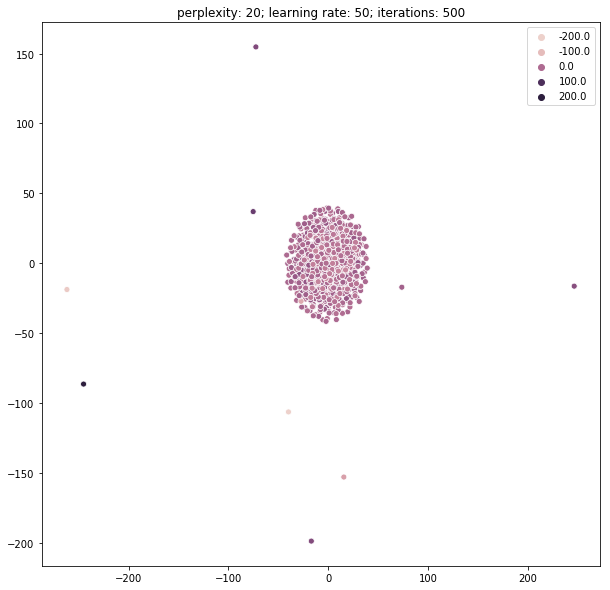

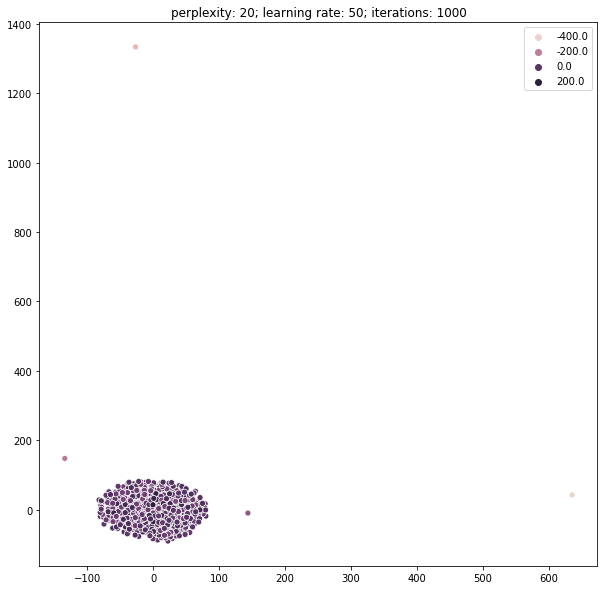

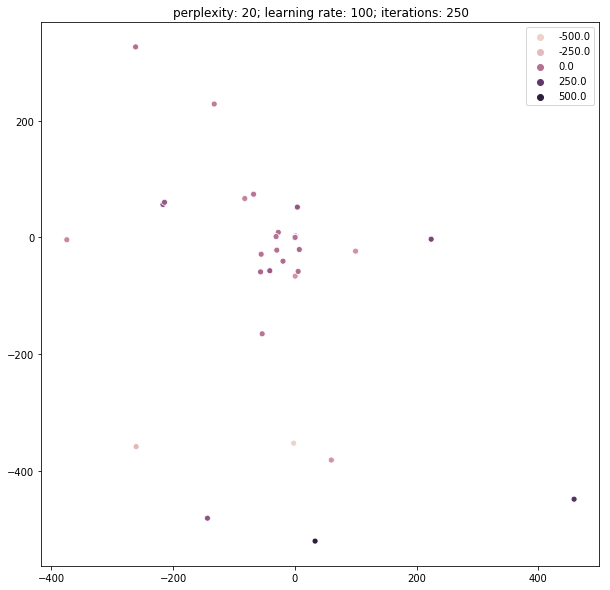

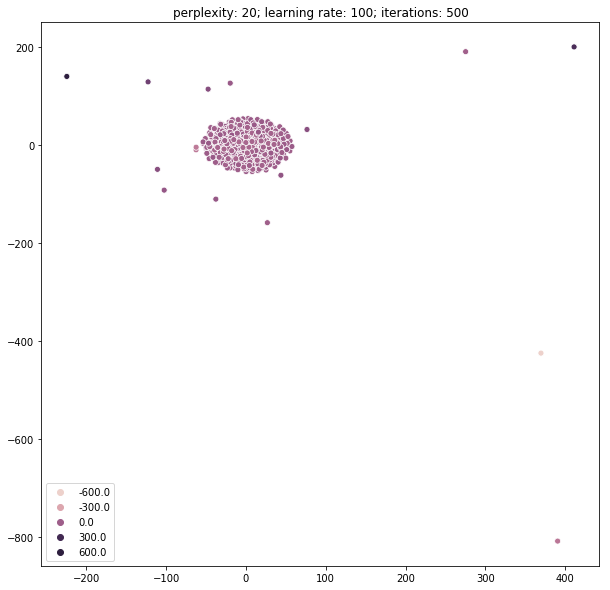

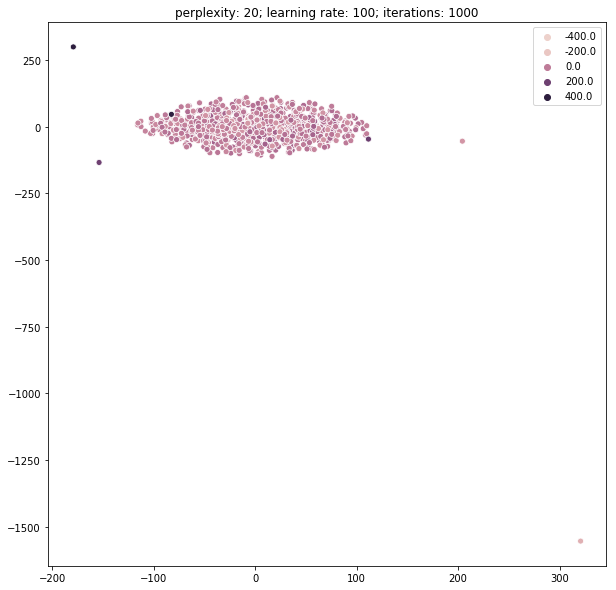

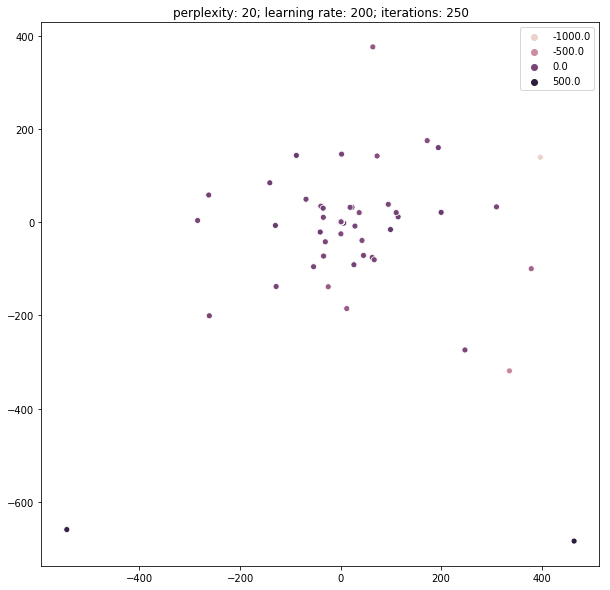

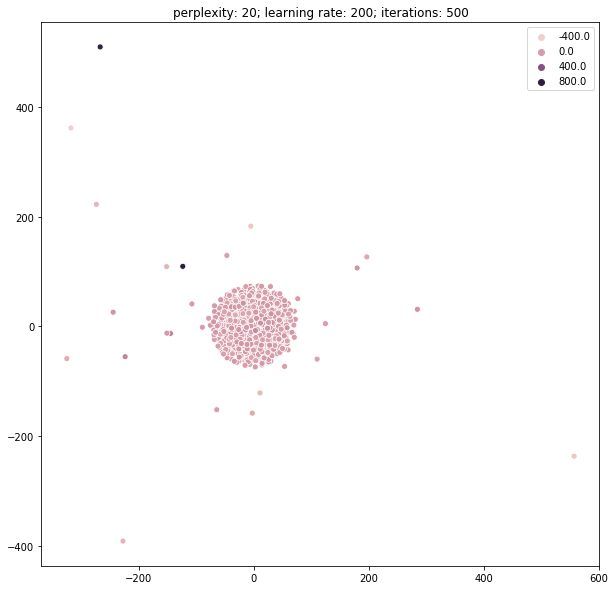

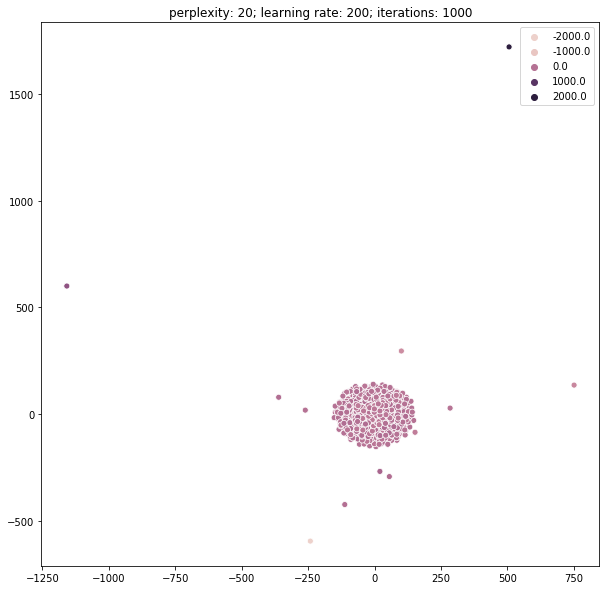

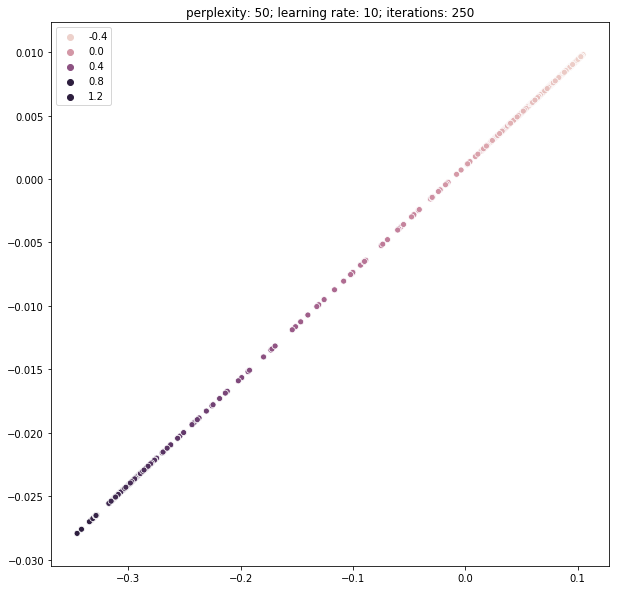

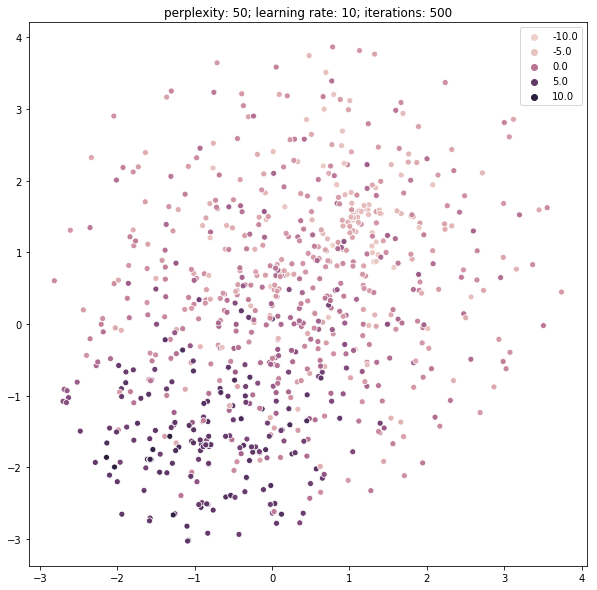

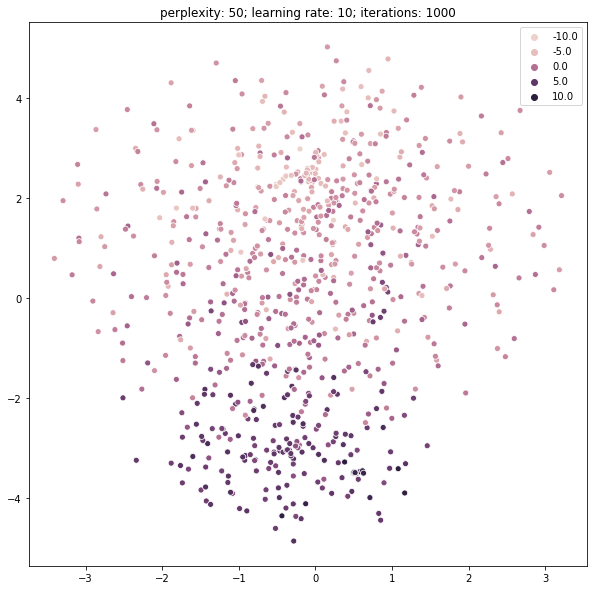

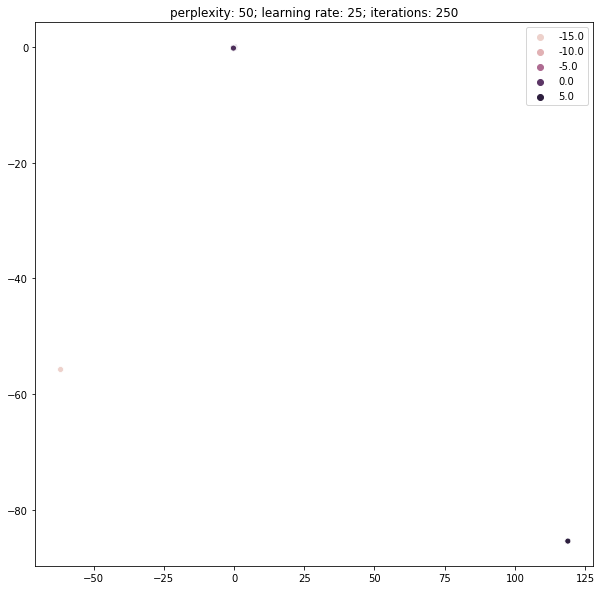

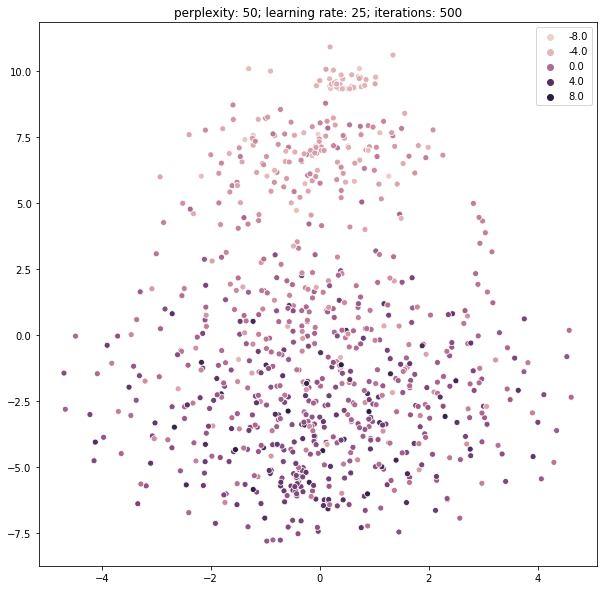

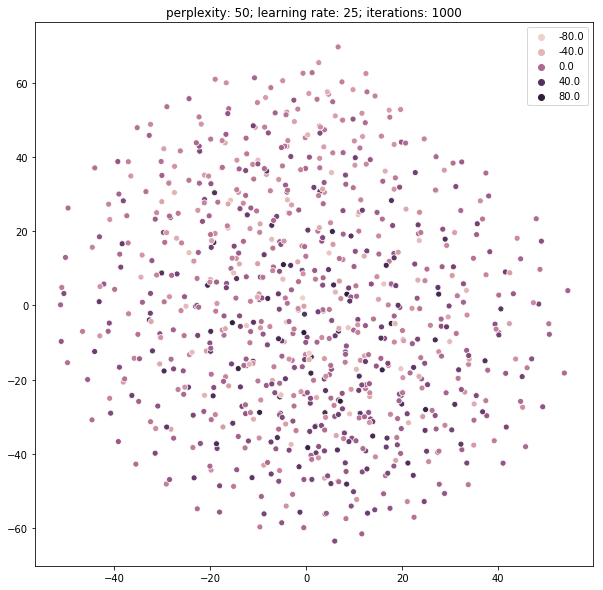

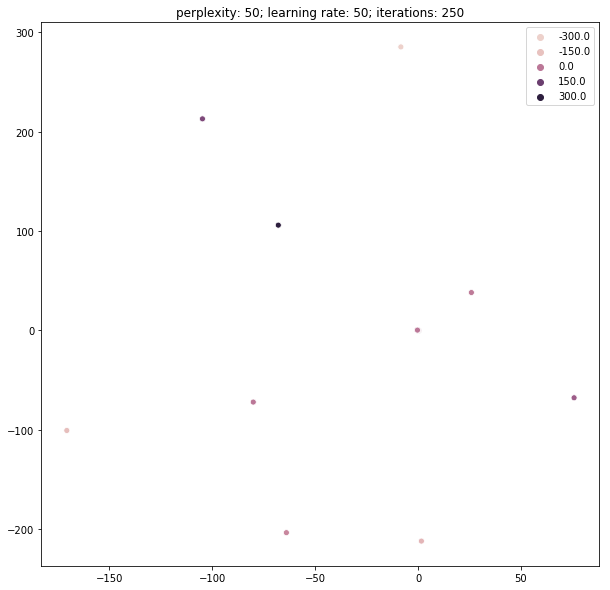

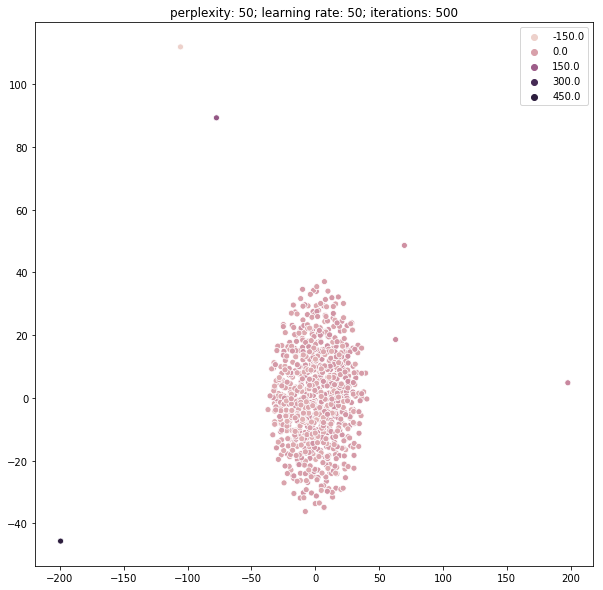

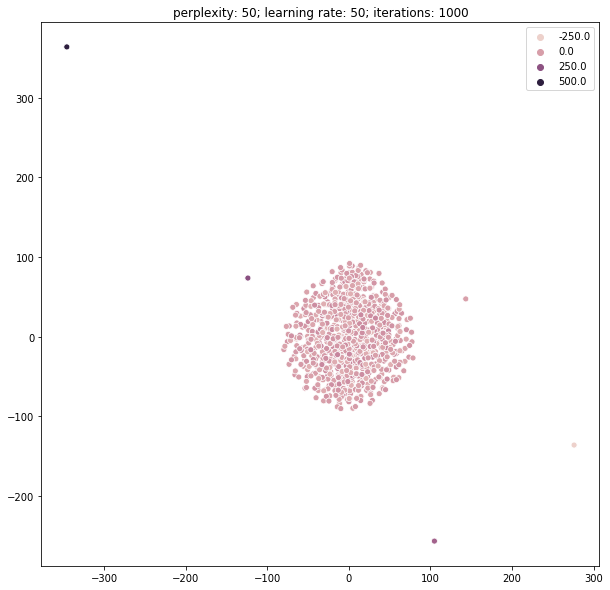

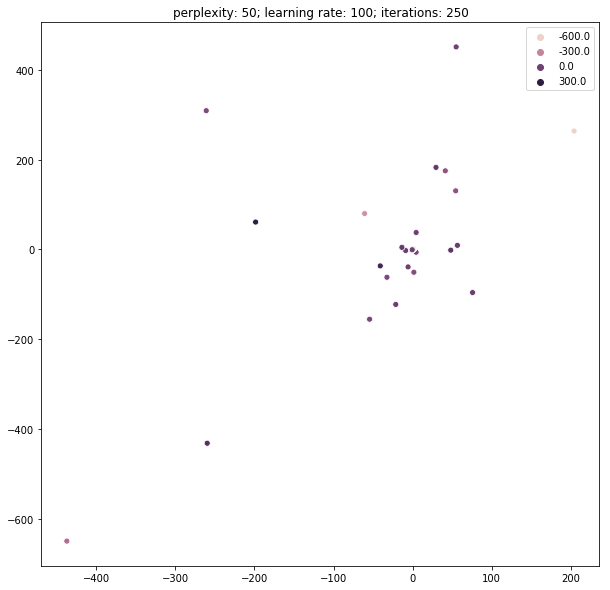

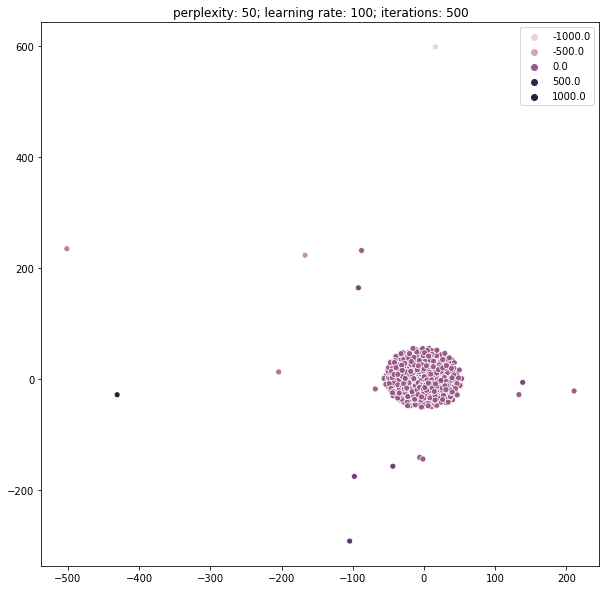

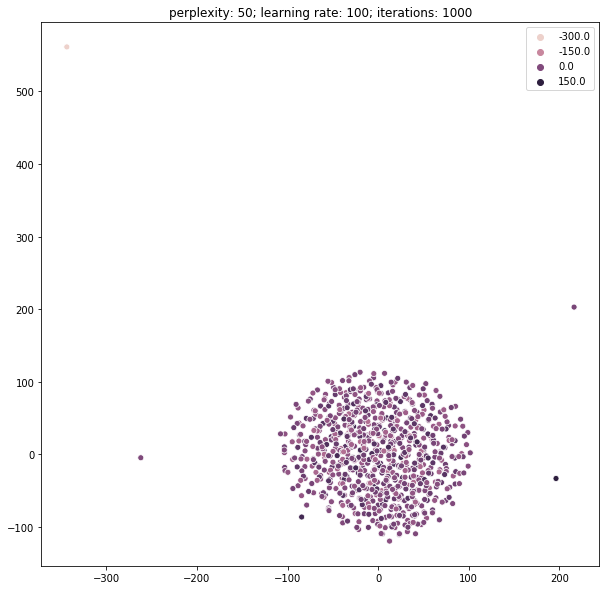

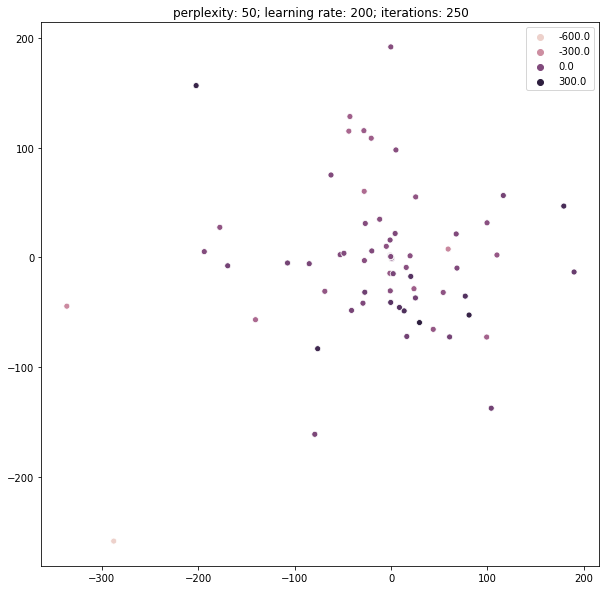

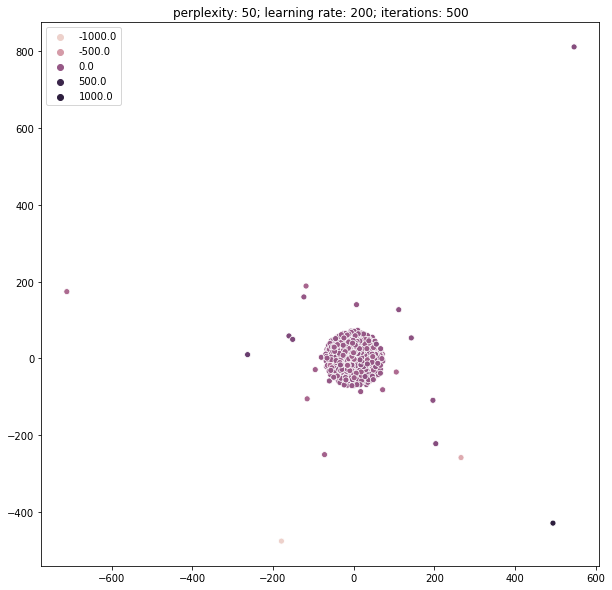

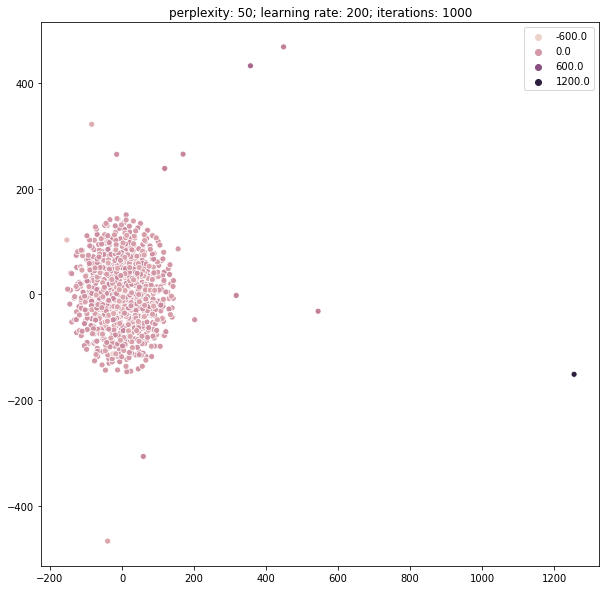

In [145]:

for perplex in range(0,len(param_grid['perplexity'])):
    for learn_rate in range(0,len(param_grid['learning_rate'])):
        for n_iter in range(0,len(param_grid['n_iter'])):
            tsne_model = TSNE(n_components=3
                          , perplexity=param_grid['perplexity'][perplex]
                          , learning_rate=param_grid['learning_rate'][learn_rate]
                          , n_iter=param_grid['n_iter'][n_iter])
            tsne_features = tsne_model.fit_transform(X = linker_matrix)
            xs = tsne_features[:,0]
            ys = tsne_features[:,1]
            zs = tsne_features[:,2]
            plt.figure(figsize = (10,10))
            plt.title('perplexity: '+str(param_grid['perplexity'][perplex])
                      +'; learning rate: '+str(param_grid['learning_rate'][learn_rate])
                      +'; iterations: '+str(param_grid['n_iter'][n_iter]))
            sns.scatterplot(xs, ys, hue=zs)

